In [31]:
import os, json
from tqdm import tqdm
from collections import defaultdict
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
import shutil
import random
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

In [3]:
#Path
image_path = "images-trainval"
train_path = r"jsonl\train.jsonl"
info_path = "jsonl\info.json"

In [4]:
#Data process
with open(info_path, "r", encoding="utf-8") as f:
    info = json.load(f)
print("Loaded info.json. Examples:", type(info))

annotations = {}
data = []

with open(train_path, "r", encoding="utf-8") as f:
    for line in tqdm(f, desc="Reading_train.jsonl"):
        item = json.loads(line)
        image_id = item.get("image_id") 
        image_file = os.path.join(image_path, f"{image_id}.jpg")
        if os.path.exists(image_file):
            data.append(item)
        else:
            print(f"There is no image {image_id}.jpg.")

Loaded info.json. Examples: <class 'dict'>


Reading_train.jsonl: 24290it [00:09, 2483.05it/s]


In [22]:
annotations = defaultdict(lambda: {
    "annotations": [],
    "ignore": [],
    "file_name": None,
    "height": None,
    "width": None
})

for item in data:
    image_id = item.get("image_id")
    
    for annotation in item.get("annotations", []):
        annotations[image_id]["annotations"].append(annotation)

    for i in item.get("ignore", []):
        annotations[image_id]["ignore"].append(i)

    annotations[image_id]["file_name"] = item.get("file_name")
    annotations[image_id]["height"] = item.get("height")
    annotations[image_id]["width"] = item.get("width")

print("Total images found in the file:", len(annotations))

Total images found in the file: 24290


In [ ]:
#Mask

def Mask_Function(image_id):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    height, width, _ = image.shape
    mask = np.zeros((height, width), dtype=np.uint8)

    for annotation in annotations[image_id]["annotations"]:
        x, y, w, h = map(int, annotation[0]["adjusted_bbox"]) 
        mask[y:y+h, x:x+w] = 1  

    return image, mask

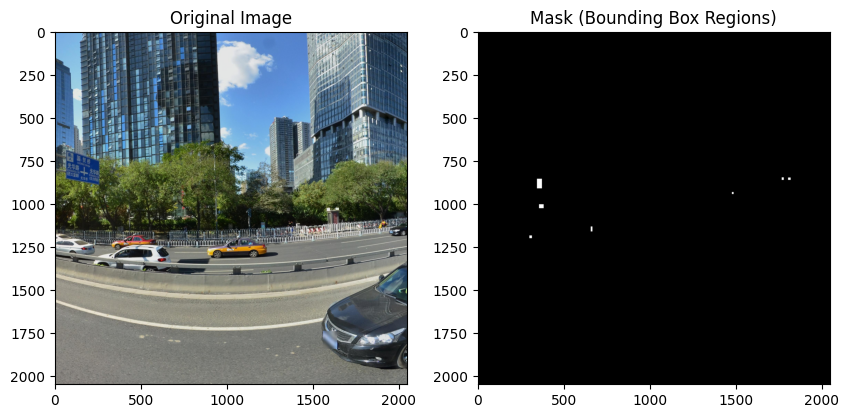

In [48]:
image_ids = list(annotations.keys())
random.shuffle(image_ids)

train_split = image_ids[:int(0.7*len(image_ids))]
val_split = image_ids[int(0.7*len(image_ids)):int(0.85*len(image_ids))]
test_split = image_ids[int(0.85*len(image_ids)):]

image, mask = Mask_Function("0000189")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask (Bounding Box Regions)")
plt.show()

In [54]:
class Dataset(Dataset):
    def __init__(self, image_ids, img_dir, annotations):
        self.image_ids = image_ids
        self.img_dir = img_dir
        self.annotations = annotations

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image, mask = Mask_Function(image_id)
        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        return image, mask

In [50]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), 
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), 
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), 
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2), 
            nn.Sigmoid()  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [51]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = self.conv_block(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        self.conv_final = nn.Conv2d(64, out_channels, 1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        out = self.conv_final(d1)
        return self.sigmoid(out)

In [52]:
train_dataset = Dataset(train_split, image_path, annotations)
val_dataset = Dataset(val_split, image_path, annotations)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model().to(device)

criterion = nn.BCELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10  

In [53]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/10, Train Loss: 0.0155


KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
    img, mask = val_dataset[0]
    img_tensor = img.unsqueeze(0).to(device)
    pred_mask = model(img_tensor)[0, 0].cpu().numpy()

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(img.permute(1,2,0))
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(mask[0], cmap="gray")
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap="hot")
plt.title("Predicted Probability Mask")
plt.show()

In [ ]:
unet_model = UNet().to(device)
optimizer_unet = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

num_epochs = 20

for epoch in range(num_epochs):
    unet_model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer_unet.zero_grad()
        outputs = unet_model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer_unet.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)
    print(f"UNet Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

In [ ]:
unet_model.eval()
with torch.no_grad():
    img, mask = val_dataset[0]
    img_tensor = img.unsqueeze(0).to(device)
    pred_mask = unet_model(img_tensor)[0, 0].cpu().numpy()

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(img.permute(1,2,0))
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(mask[0], cmap="gray")
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap="hot")
plt.title("UNet Predicted Mask")
plt.show()

torch.save(model.state_dict(), "simple_cnn.pth")
torch.save(unet_model.state_dict(), "unet_model.pth")

In [9]:
for image_id, info in list(annotations.items())[:2]:
    print(image_id)
    print(type(info["annotations"]))
    print(len(info["annotations"]))
    print("First item type:", type(info["annotations"][0]))
    print("First item content:")
    print(info["annotations"][0])
    break



0000172
<class 'list'>
10
First item type: <class 'list'>
First item content:
[{'adjusted_bbox': [140.26028096262758, 897.1957001682758, 22.167573140645146, 38.36424196832945], 'attributes': ['distorted', 'raised'], 'is_chinese': True, 'polygon': [[140.26028096262758, 896.7550603352049], [162.42785410327272, 898.0769798344178], [162.42785410327272, 935.7929346470926], [140.26028096262758, 935.0939571156308]], 'text': '明'}, {'adjusted_bbox': [162.42785410327272, 898.5416545674744, 23.376713493771263, 37.74268246537315], 'attributes': ['distorted', 'raised'], 'is_chinese': True, 'polygon': [[162.42785410327272, 898.0769798344178], [185.80456759704398, 899.4710040335876], [185.80456759704398, 936.5300382257251], [162.42785410327272, 935.7929346470926]], 'text': '海'}, {'adjusted_bbox': [185.80456759704398, 899.90363223333, 21.764526356269812, 37.08391855844286], 'attributes': ['distorted', 'raised'], 'is_chinese': True, 'polygon': [[185.80456759704398, 899.4710040335876], [207.569093953313

In [ ]:
chars = []
for image_id, information in annotations.items():
    for item in information["annotations"]:  
        for annotation in item:
            if annotation.get("is_chinese"):
                chars.append({
                    "image_id": image_id,
                    "char": annotation["text"],
                    "bbox": annotation["adjusted_bbox"],
                    "attributes": annotation["attributes"]
                })

print(f"提取出 {len(chars)} 个汉字")
print(chars[:1])

提取出 760107 个汉字
[{'image_id': '0000172', 'char': '明', 'bbox': [140.26028096262758, 897.1957001682758, 22.167573140645146, 38.36424196832945], 'attributes': ['distorted', 'raised']}]


In [ ]:
count = 0
os.makedirs("chars", exist_ok=True)

for entry in tqdm(chars):
    image_id = entry["image_id"]
    char_label = entry["char"]
    bbox = entry["bbox"]

    image_path = os.path.join("images-trainval", f"{image_id}.jpg")
    image = cv2.imread(image_path)
    if image is None:
        print(f"{image_path} pass")
        continue

    x, y, w, h = map(int, bbox)
    x, y = max(0, x), max(0, y)
    w, h = max(1, w), max(1, h)
    char_img = image[y:y+h, x:x+w]

    save_dir = os.path.join("chars", char_label)
    os.makedirs(save_dir, exist_ok=True)
    img_name = f"{image_id}_{count}.jpg"
    save_path = os.path.join(save_dir, img_name)

    _, encoded_image = cv2.imencode(".jpg", char_img)
    encoded_image.tofile(save_path)

    count += 1

print(f"共保存 {count} 张汉字图片")


100%|██████████| 760107/760107 [4:21:41<00:00, 48.41it/s]  

共保存 760107 张汉字图片


In [28]:
records = []

for char_label in os.listdir("chars"):
    folder = os.path.join("chars", char_label)
    if not os.path.isdir(folder):
        continue
    for img_name in os.listdir(folder):
        records.append({
            "image_path": os.path.join(folder, img_name),
            "label": char_label
        })

df = pd.DataFrame(records)
df.to_csv("chars_labels.csv", index=False, encoding="utf-8-sig")
print(f"共记录 {len(df)} 张汉字及标签")

共记录 760107 张汉字及标签


In [32]:
split_ratio = [0.8, 0.1, 0.1]
splits = ["train", "val", "test"]

for split in splits:
    os.makedirs(os.path.join("dataset", split), exist_ok=True)

def copy_image(src, dst):
    shutil.copy2(src, dst)

for char_label in tqdm(os.listdir("chars"), desc="Processing labels"):
    char_folder = os.path.join("chars", char_label)
    images = os.listdir(char_folder)
    random.shuffle(images)
    total = len(images)
    train_end = int(split_ratio[0]*total)
    val_end = train_end + int(split_ratio[1]*total)

    subsets = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, selected in subsets.items():
        split_dir = os.path.join("dataset", split, char_label)
        os.makedirs(split_dir, exist_ok=True)

        with ThreadPoolExecutor(max_workers=8) as executor:
            list(tqdm(
                executor.map(
                    lambda img: copy_image(os.path.join(char_folder, img),
                                           os.path.join(split_dir, img)),
                    selected
                ),
                total=len(selected),
                desc=f"{char_label}-{split}",
                leave=False
            ))

Processing labels: 100%|██████████| 3580/3580 [14:43<00:00,  4.05it/s] 


In [33]:
class Chinese_CNN_Model(nn.Module):
    def __init__(self, num_classes):
        super(Chinese_CNN_Model, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
        )
        self.dropout = nn.Dropout(0.25)
        self.fc_layers = nn.Sequential(
            nn.Linear(128*8*8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes) 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [35]:
empty_classes = []
for c in os.listdir("dataset/train"):
    if not os.listdir(os.path.join("dataset/train", c)):
        empty_classes.append(c)

print("Empty classes:", empty_classes[:10])
print("Total empty:", len(empty_classes))

Empty classes: ['丈', '丑', '且', '乃', '亢', '仃', '伐', '伪', '侈', '俬']
Total empty: 317


In [36]:
root_dir = "dataset"
for split in ["train", "val", "test"]:
    split_dir = os.path.join(root_dir, split)
    for char_label in os.listdir(split_dir):
        char_path = os.path.join(split_dir, char_label)
        if not os.listdir(char_path):  # 文件夹为空
            os.rmdir(char_path)
            print(f"Deleted empty folder: {char_path}")

Deleted empty folder: dataset\train\丈
Deleted empty folder: dataset\train\丑
Deleted empty folder: dataset\train\且
Deleted empty folder: dataset\train\乃
Deleted empty folder: dataset\train\亢
Deleted empty folder: dataset\train\仃
Deleted empty folder: dataset\train\伐
Deleted empty folder: dataset\train\伪
Deleted empty folder: dataset\train\侈
Deleted empty folder: dataset\train\俬
Deleted empty folder: dataset\train\倉
Deleted empty folder: dataset\train\個
Deleted empty folder: dataset\train\偢
Deleted empty folder: dataset\train\偭
Deleted empty folder: dataset\train\傢
Deleted empty folder: dataset\train\傣
Deleted empty folder: dataset\train\僅
Deleted empty folder: dataset\train\儲
Deleted empty folder: dataset\train\允
Deleted empty folder: dataset\train\兢
Deleted empty folder: dataset\train\內
Deleted empty folder: dataset\train\兩
Deleted empty folder: dataset\train\兮
Deleted empty folder: dataset\train\冥
Deleted empty folder: dataset\train\凔
Deleted empty folder: dataset\train\凖
Deleted empt

In [38]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root="dataset/train", transform=transform)
val_dataset   = datasets.ImageFolder(root="dataset/val", transform=transform)
test_dataset  = datasets.ImageFolder(root="dataset/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)
num_classes = len(train_dataset.classes)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Chinese_CNN_Model(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

KeyboardInterrupt: 

In [13]:
def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return acc, precision, recall, f1

test_acc, test_prec, test_rec, test_f1 = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Precision: {test_prec*100:.2f}%")
print(f"Test Recall: {test_rec*100:.2f}%")
print(f"Test F1-score: {test_f1*100:.2f}%")

NameError: name 'model' is not defined

In [14]:
test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc*100:.2f}%")

NameError: name 'model' is not defined

In [15]:
torch.save(model.state_dict(), "Chinese_CNN_Model.pth")
print("Save successfully")

NameError: name 'model' is not defined